## ESC-50 Audio Classification Pipeline
## Complete workflow from data loading to real-time prediction

## 1. Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from vgg_utils import vggish_input
from vgg_utils import vggish_params
from vgg_utils import vggish_postprocess
from vgg_utils import vggish_slim

# Configuration
AUDIO_DIR = 'audio'
META_PATH = 'esc50.csv'
SAMPLE_RATE = 16000
CHECKPOINT_PATH = 'vggish_model.ckpt'
PCA_PARAMS_PATH = 'vggish_pca_params.npz'

# Load metadata
# meta = pd.read_csv(r'C:\Users\umarf\Desktop\urban_noise_prediction_web\meta\esc50.csv')
meta = pd.read_csv(r'D:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\meta\esc50.csv')
print(f"Dataset contains {len(meta)} samples")
meta.head()




Dataset contains 2000 samples


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


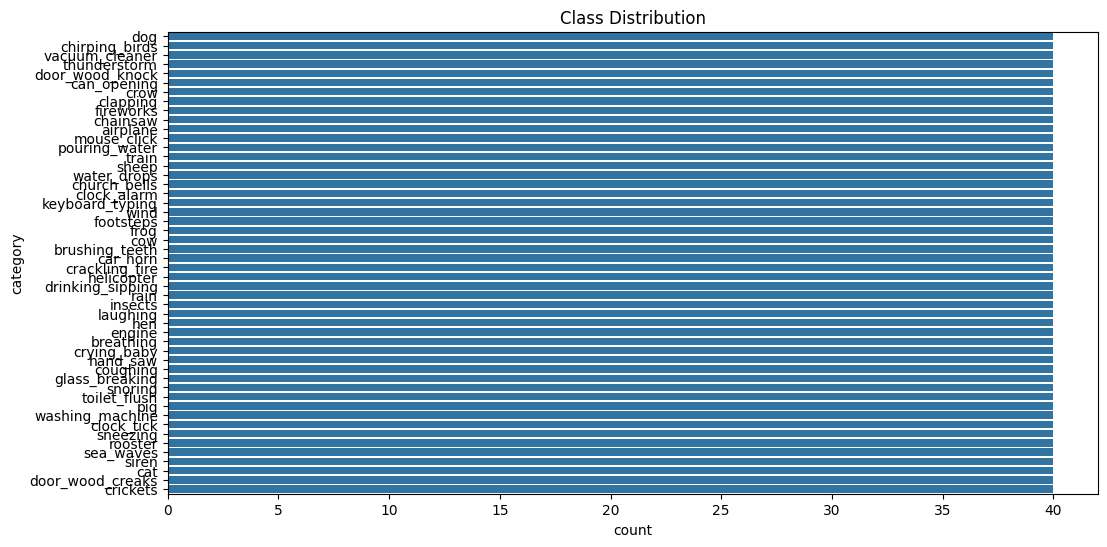

In [2]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=meta, y='category', order=meta['category'].value_counts().index)
plt.title('Class Distribution')
plt.savefig('Class Distribution.png')
plt.show()


## 2. Data Preprocessing

In [3]:
def setup_vggish():
    pproc = vggish_postprocess.Postprocessor(PCA_PARAMS_PATH)
    graph = tf.Graph()
    sess = tf.Session(graph=graph)
    
    with graph.as_default():
        vggish_slim.define_vggish_slim(training=False)
        saver = tf.train.Saver()
        saver.restore(sess, CHECKPOINT_PATH)
        features_tensor = graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
    
    return sess, graph, features_tensor, embedding_tensor, pproc

def extract_features(audio_path, sess, features_tensor, embedding_tensor, pproc):
    try:
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)
        examples = vggish_input.waveform_to_examples(y, sr)
        [embeddings] = sess.run([embedding_tensor], feed_dict={features_tensor: examples})
        postprocessed = pproc.postprocess(embeddings)
        return np.mean(postprocessed, axis=0)  # Temporal mean pooling
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

# Initialize VGGish
sess, graph, features_tensor, embedding_tensor, pproc = setup_vggish()

C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '



INFO:tensorflow:Restoring parameters from vggish_model.ckpt


## 3. Exploratory Data Analysis (EDA)

In [4]:
import os
from pathlib import Path

# Convert to absolute paths
AUDIO_DIR = Path(r'audio').absolute()
META_PATH = Path(r'D:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\meta\esc50.csv').absolute()

# Verify paths exist
print(f"Audio directory exists: {AUDIO_DIR.exists()}")
print(f"Metadata file exists: {META_PATH.exists()}")

# Reload metadata with absolute paths
meta = pd.read_csv(r'D:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\meta\esc50.csv')
meta['filepath'] = meta['filename'].apply(lambda x: str(AUDIO_DIR/x))

# Check first 5 files exist
for i, row in meta.head().iterrows():
    print(f"File {row['filepath']} exists: {Path(row['filepath']).exists()}")

# Feature extraction for EDA with error handling
sample_features = []
valid_samples = []

for _, row in meta[:20].iterrows():  # Check first 20 samples
    try:
        if not Path(row['filepath']).exists():
            print(f"File not found: {row['filepath']}")
            continue
            
        features = extract_features(row['filepath'], sess, features_tensor, embedding_tensor, pproc)
        if features is not None:
            sample_features.append(features)
            valid_samples.append(row)
    except Exception as e:
        print(f"Error processing {row['filepath']}: {str(e)}")


Audio directory exists: True
Metadata file exists: True
File d:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\audio\1-100032-A-0.wav exists: True
File d:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\audio\1-100038-A-14.wav exists: True
File d:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\audio\1-100210-A-36.wav exists: True
File d:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\audio\1-100210-B-36.wav exists: True
File d:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\audio\1-101296-A-19.wav exists: True


# Visualize only if we have samples

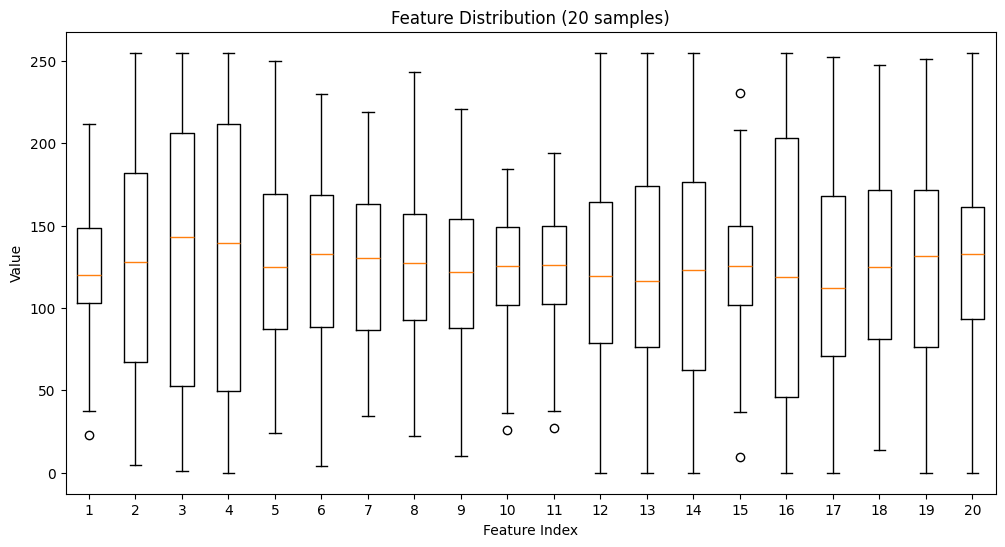

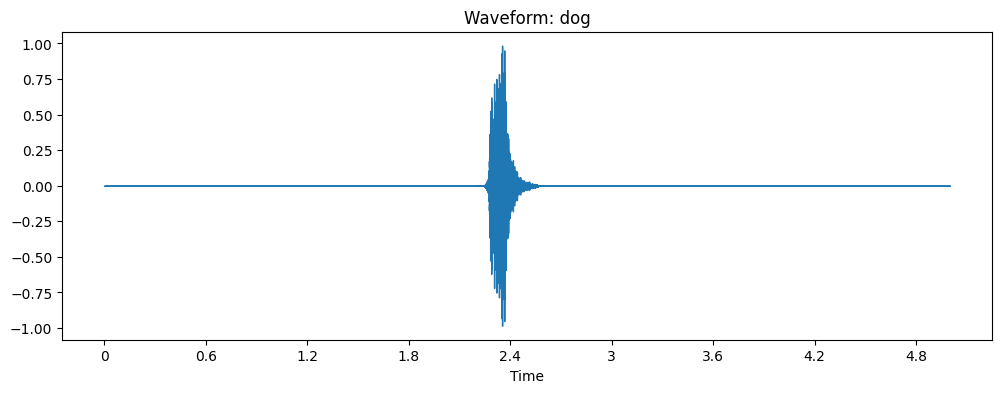

In [5]:
if len(sample_features) > 0:
    # Feature distributions
    plt.figure(figsize=(12, 6))
    plt.boxplot(sample_features)
    plt.title(f'Feature Distribution ({len(sample_features)} samples)')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    plt.savefig('Feature_Distribution.png')
    plt.show()
    
    # Waveform visualization
    plt.figure(figsize=(12, 4))
    y, sr = librosa.load(valid_samples[0]['filepath'], sr=SAMPLE_RATE)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {valid_samples[0]['category']}")
    plt.savefig('Waveform.png')
    plt.show()
    
    # Play sample
    display(Audio(filename=valid_samples[0]['filepath']))
else:
    print("No valid samples found for EDA!")

## 4. Data Splitting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Extract features for all files
features = []
labels = []
for _, row in meta.iterrows():
    feat = extract_features(f"{AUDIO_DIR}/{row['filename']}", sess, features_tensor, embedding_tensor, pproc)
    if feat is not None:
        features.append(feat)
        labels.append(row['category'])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
X = np.array(features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1600, 128), Test shape: (400, 128)


 ## 5. Model Selection & Building

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Define models
models = {
    'RandomForest': make_pipeline(
        StandardScaler(),
        RandomForestClassifier(random_state=42)
    ),
    'SVM': make_pipeline(
        StandardScaler(),
        SVC(probability=True, random_state=42)
    ),
    'MLP': make_pipeline(
        StandardScaler(),
        MLPClassifier(early_stopping=True, random_state=42)
    )
}

# Parameter grids
param_grids = {
    'RandomForest': {
        'randomforestclassifier__n_estimators': [100, 200],
        'randomforestclassifier__max_depth': [None, 10, 20]
    },
    'SVM': {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf']
    },
    'MLP': {
        'mlpclassifier__hidden_layer_sizes': [(128,), (256,)],
        'mlpclassifier__alpha': [0.0001, 0.001]
    }
}

## 6. Training & Evaluation


Training RandomForest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 200}
Test accuracy: 0.7350

Training SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'svc__C': 10, 'svc__kernel': 'rbf'}
Test accuracy: 0.8200

Training MLP...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (256,)}
Test accuracy: 0.7575

Best model evaluation:
                  precision    recall  f1-score   support

        airplane       0.71      0.62      0.67         8
       breathing       0.70      0.88      0.78         8
  brushing_teeth       1.00      1.00      1.00         8
     can_opening       0.43      0.75      0.55         8
        car_horn       0.89      1.00      0.94         8
             cat       0.60      0.75      0.67         8
        chainsaw      

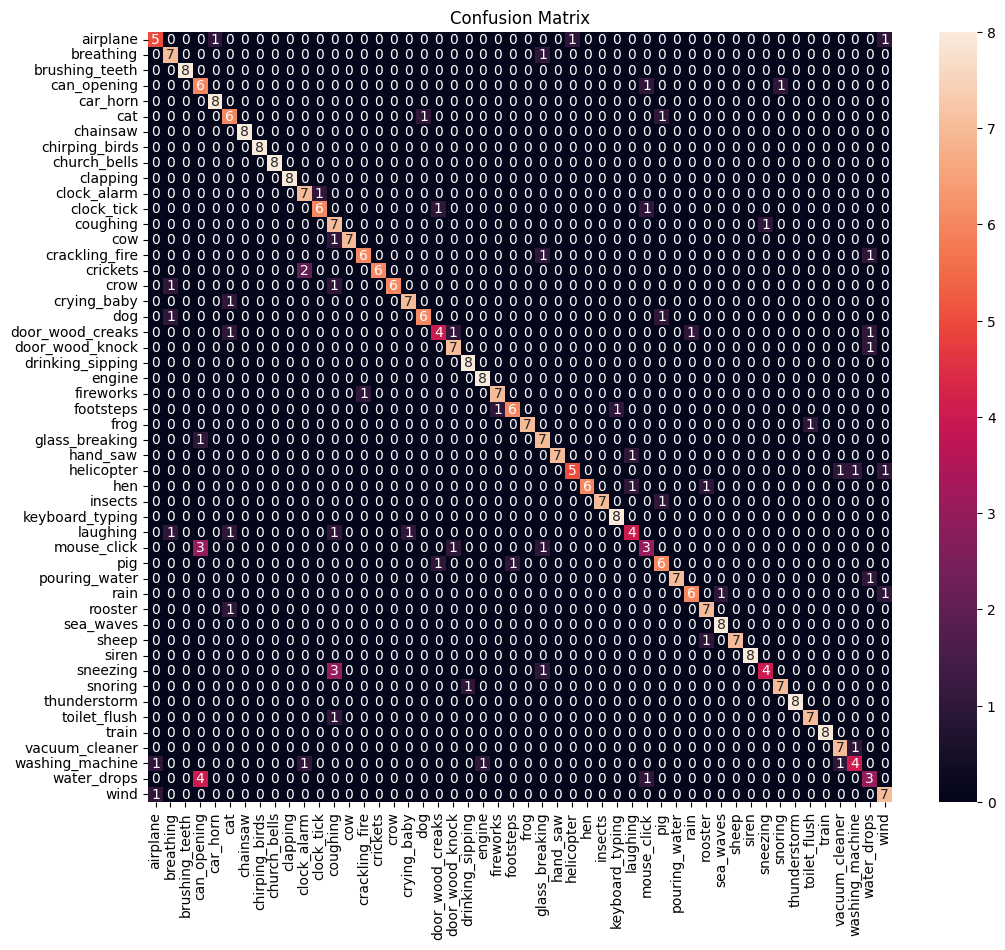

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

best_score = 0
best_model = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    # Evaluate
    test_score = grid.score(X_test, y_test)
    print(f"Best params: {grid.best_params_}")
    print(f"Test accuracy: {test_score:.4f}")
    
    if test_score > best_score:
        best_score = test_score
        best_model = grid.best_estimator_

# Final evaluation
print("\nBest model evaluation:")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.savefig('Confusion_Matrix.png')
plt.show()


## 7. Model Saving

In [9]:
import joblib

# Save model artifacts
joblib.dump({
    'model': best_model,
    'label_encoder': le,
    'classes': le.classes_
}, 'best_audio_classifier.pkl')

print("Model saved successfully!")

Model saved successfully!


## 8. Real-time Prediction

In [10]:
def predict_audio(audio_path):
    # Load model
    artifacts = joblib.load('best_audio_classifier.pkl')
    model = artifacts['model']
    le = artifacts['label_encoder']
    
    # Extract features
    sess, graph, ft, et, pp = setup_vggish()
    features = extract_features(audio_path, sess, ft, et, pp)
    sess.close()
    
    if features is None:
        return "Error processing audio"
    
    # Predict
    features = features.reshape(1, -1)
    proba = model.predict_proba(features)[0]
    pred_idx = np.argmax(proba)
    
    return {
        'prediction': le.classes_[pred_idx],
        'confidence': proba[pred_idx],
        'probabilities': {cls: float(prob) for cls, prob in zip(le.classes_, proba)}
    }

# Test prediction
sample_audio = f"{AUDIO_DIR}/{meta.iloc[2]['filename']}"
print(f"Predicting: {sample_audio}")
display(Audio(filename=sample_audio))
predict_audio(sample_audio)

Predicting: d:\SDP\urban_noise_prediction_web\urban_noise_prediction_web\audio/1-100210-A-36.wav


INFO:tensorflow:Restoring parameters from vggish_model.ckpt


C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


{'prediction': np.str_('vacuum_cleaner'),
 'confidence': np.float64(0.8672798588954183),
 'probabilities': {np.str_('airplane'): 0.009875666033790441,
  np.str_('breathing'): 0.0010659200833029734,
  np.str_('brushing_teeth'): 0.0020311772977874127,
  np.str_('can_opening'): 0.0010354419377145492,
  np.str_('car_horn'): 0.0017284996876252613,
  np.str_('cat'): 0.0010145934260746496,
  np.str_('chainsaw'): 0.0029106976007344985,
  np.str_('chirping_birds'): 0.002341781345306389,
  np.str_('church_bells'): 0.001784704319754518,
  np.str_('clapping'): 0.0021269412881631785,
  np.str_('clock_alarm'): 0.003106464521538339,
  np.str_('clock_tick'): 0.003095246735141061,
  np.str_('coughing'): 0.0009501021560150209,
  np.str_('cow'): 0.0009469259656527551,
  np.str_('crackling_fire'): 0.005260206964463006,
  np.str_('crickets'): 0.0028856506855441926,
  np.str_('crow'): 0.0017923877456777803,
  np.str_('crying_baby'): 0.0007327313346686182,
  np.str_('dog'): 0.0016437679116770203,
  np.str_('